export HDF5_USE_FILE_LOCKING=FALSE

In [1]:
import sys
from brahma_analysis import *
from scipy.interpolate import interp1d
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import scipy.interpolate
import h5py
import os
import numpy as np
import plotting
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import time
from scipy.signal import savgol_filter
from scipy.optimize import brentq
from scipy.optimize import curve_fit

%matplotlib inline
radiative_efficiency=0.2

# Testing Kinematic_Decomop.py:

In [ ]:
import sys
from brahma_analysis import *
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import h5py
import os
import numpy as np

TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(basePath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

# Determining size of subhalos
fields=['SubhaloLenType']
Subhalo_lengths = il.groupcat.loadSubhalos(basePath,snap_num,fields=fields)

SubhaloBHLen = Subhalo_lengths[:,5] # Number of BHs in each subhalo
SubhaloStarsLen = Subhalo_lengths[:,4] # Number of Stars in each subhalo
SubhaloIndices = np.arange(0,len(SubhaloBHLen)) # Indices of subhalos
mask1 = np.logical_and(SubhaloBHLen>0,SubhaloStarsLen>1000)  # Only subhalos with a BH and with 1000 stars
Desired_subhalos = SubhaloIndices[mask1] # Only indices of subhalos we want

Desired_subhalos = SubhaloIndices[mask1] # Only indices of subhalos we want

# Load in all subhalo positions and velocities 
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel'])
Centrals = il.groupcat.loadHalos(basePath=basePath,snapNum=snap_num,fields='GroupFirstSub')
Central_subhalos = Centrals[Centrals!=-1]

# Initialize lists to append to
Ratios = []
Sigmas = []
BH_Masses = []
Star_Masses = []
Coords = []
e_bind_norms = []
Pot_radii = []
Pot_grads = []
Central_ids = []
Subhalo_vels = []
failed_subhalos = 0

# Now looping through all subhalos with BHs and 1000 stars
for index in Desired_subhalos:
        
    fields = ['BH_Mass']
    Subhalo_BH_Masses = il.snapshot.loadSubhalo(basePath, snapNum=snap_num, id=index, partType=5, fields=fields)

    # Load in star properties of current halo
    fields = ['Masses','Coordinates','Velocities','Potential']
    Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=index, partType=4, fields=fields)
    Star_Mass=Star_Props['Masses']*1e10/h # Units: Msun

    # Center coord and vel and correct units
    Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=index)
    
    # Calculating specific binding energy
    e_bind = 0.5*np.linalg.norm(np.array(Velocities)**2,axis=1) + Potentials

    # Normalizing to max binding energy
    e_bind_norm = e_bind/np.abs(np.min(e_bind))
    
    # Calculate id's of stars in the bulge
    pos,grad,ratio,negids,rcs,potential_binned,gradient_interp,potental_interp = kinematic_decomp_e(Coordinates,Velocities,Potentials)
    Velocities[negids] = np.nan

    bulge = ratio < 0.5

    Bulge_vel = Velocities[bulge]
    Bulge_mass = Star_Mass[bulge]

    # Calculate the velocity dispersion

    Mstars_total = np.sum(Bulge_mass) # Total stellar mass

    # Here we weight the sigma calculation by stellar mass
    mu_vel = np.mean(Bulge_vel,axis=0) # Average 3D stellar velocity for this subhalo
    DiffSquared=Bulge_mass[:, np.newaxis]*np.array((Bulge_vel - mu_vel)** 2)

    Sigma_halo = np.sqrt(np.sum(DiffSquared,axis=0) / Mstars_total)  # Calculate sigma from subhalo velocity

    Sigmas.append(Sigma_halo)
    BH_Masses.append(np.max(Subhalo_BH_Masses)) # Add most massive BH mass in subhalo to list
    Ratios.append(ratio) # Append the ratio of jz/jcirc for stars in the subhalo
    Coords.append(Coordinates)
    Star_Masses.append(Star_Mass)
    e_bind_norms.append(e_bind_norm)
    Pot_radii.append(pos)
    Pot_grads.append(grad)
    Subhalo_vels.append(Velocities)
    
    if index in Central_subhalos:
        Central_ids.append(index)
    else:
        Central_ids.append(-1) # A value of -1 indicates the the subhalo is not a central

    if len(ratio[~np.isnan(ratio)]) == 0:
        failed_subhalos += 1
        print("Subhalo {} failed".format(index))
    else:
        print('Subhalo: {},'.format(index),'Sigma: {},'.format(np.linalg.norm(Sigma_halo)),'BH mass: {},'.format(np.max(Subhalo_BH_Masses)),
         'Ratio max/min: {},'.format((np.max(ratio),np.min(ratio)) ) )

failure_rate = failed_subhalos/len(Desired_subhalos)
print("Failure rate: {}".format(failure_rate))

Write2File(Ratios,Sigmas,BH_Masses,Coords,Star_Masses,Pot_radii,Pot_grads,e_bind_norms,
           Central_ids,Subhalo_vels,fname='Brahma_Data/Kin_Decomp_TNG_z0_r0.5_e')

# Testing code:

In [2]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [9]:
fields=['SubhaloLenType']

Subhalo_lengths = il.groupcat.loadSubhalos(basePath,snap_num,fields=fields)
SubhaloBHLen = Subhalo_lengths[:,5] # Number of BHs in each subhalo
SubhaloStarsLen = Subhalo_lengths[:,4] # Number of Stars in each subhalo
SubhaloIndices = np.arange(0,len(SubhaloBHLen)) # Indices of subhalos
mask1 = np.logical_and(SubhaloBHLen>0,SubhaloStarsLen>1000)  # Only subhalos with a BH and with 1000 stars
Desired_subhalos = SubhaloIndices[mask1]

In [11]:
# for i in range(40,100):
subhalo_id = 50 # Desired_subhalos[i] # 31424
# print("Subhalo {}".format(Desired_subhalos[i]))
kpc2km = 3.0857e16
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel'])
fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=subhalo_id, partType=4, fields=fields)

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=subhalo_id)

# start_time = time.perf_counter()

pos,grad,ratio2,negids,rcs,potential_binned,gradient_interp,potental_interp = kinematic_decomp_e(Coordinates,Velocities,Potentials)

# Code to be timed
# end_time = time.perf_counter()
# elapsed_time = end_time - start_time
# print("Time to do decomp: {} seconds".format(elapsed_time))

e_bind = 0.5*np.linalg.norm(np.array(Velocities)**2,axis=1) + Potentials

# Normalizing to max binding energy
e_bind_norm = e_bind/np.abs(np.min(e_bind))

pos /= kpc2km

Nonzero rcs: 27025 Skipped stars: 43


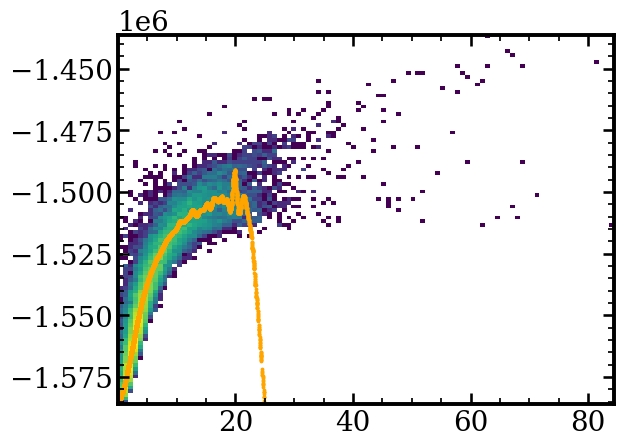

In [22]:
rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
mask = rstars < 25*kpc2km
masked_rstars = rstars[mask]
masked_Potentials = Potentials[mask]
masked_Velocities = Velocities[mask]
interp_g = np.array([gradient_interp(i) for i in masked_rstars])
interp_p = np.array([potental_interp(i) for i in masked_rstars])
f1 = np.array([interp_p + 0.5*masked_rstars*interp_g])

vals = [Potentials[i] + 0.5*np.linalg.norm(Velocities[i])**2 for i in range(len(Potentials))]
counts1, xedges1, yedges1, im1 = plt.hist2d(rstars/kpc2km,vals,norm='log',bins=100)
plt.scatter(masked_rstars/kpc2km,f1,s = 3,color='orange')


/tmp/ipykernel_281518/859725969.py:10: RuntimeWarning: invalid value encountered in sqrt
  vcirc = np.sqrt(masked_rstars * interp_g)


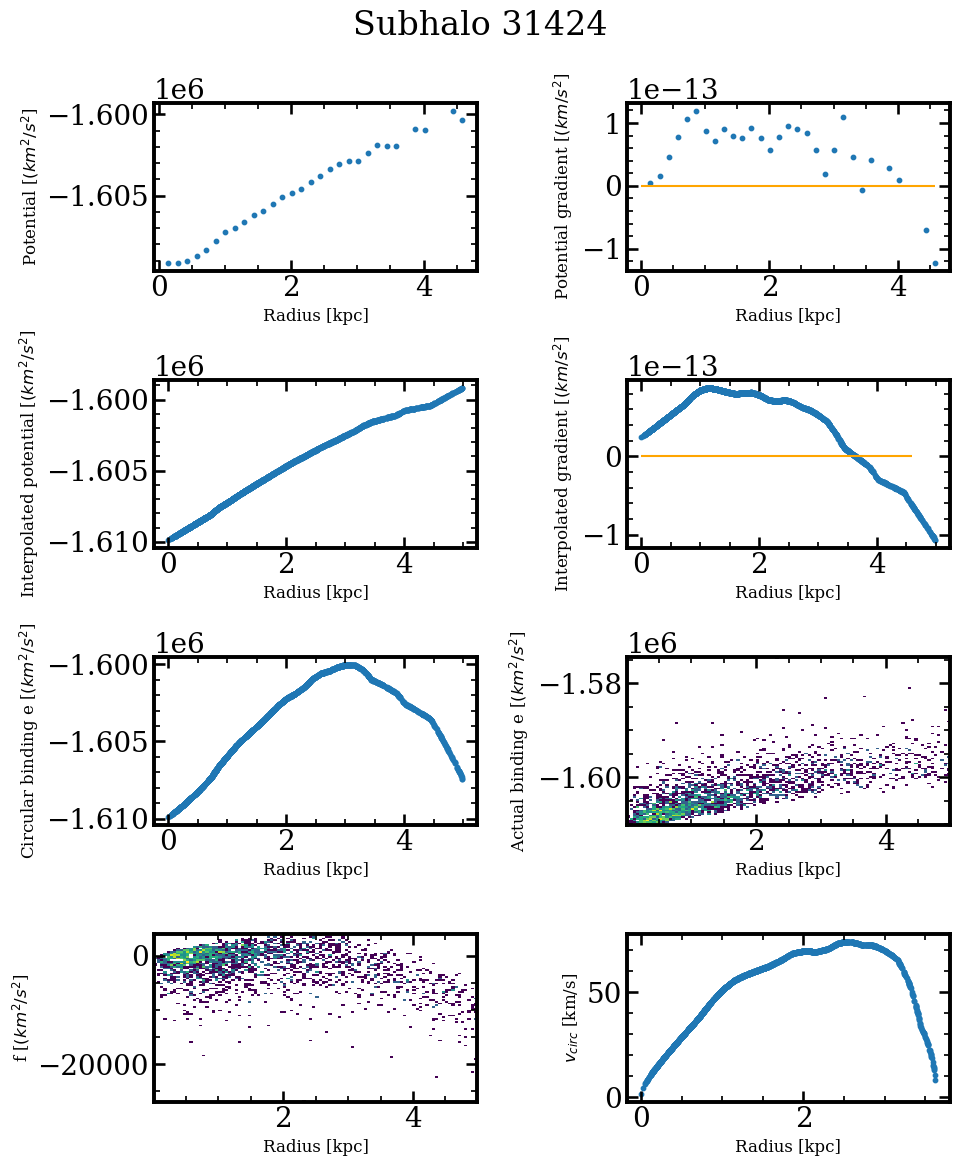

In [7]:
fig,axs = plt.subplots(4,2,figsize=(10,12))

rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
mask = rstars < 5*kpc2km
masked_rstars = rstars[mask]
masked_Potentials = Potentials[mask]
masked_Velocities = Velocities[mask]
interp_g = np.array([gradient_interp(i) for i in masked_rstars])
interp_p = np.array([potental_interp(i) for i in masked_rstars])
vcirc = np.sqrt(masked_rstars * interp_g)

f1 = np.array([interp_p + 0.5*masked_rstars*interp_g])
f2 = masked_Potentials + 0.5*np.linalg.norm(masked_Velocities,axis=1)**2
f = f1 - f2

axs[0,0].scatter(pos,potential_binned,s = 10)
axs[0,0].set_xlabel("Radius [kpc]",size=12)
axs[0,0].set_ylabel("Potential [$(km^2/s^{2}$]",size=12)

axs[0,1].scatter(pos,grad,s = 10)
axs[0,1].hlines(0,0,np.max(pos),color='orange')
axs[0,1].set_xlabel("Radius [kpc]",size=12)
axs[0,1].set_ylabel("Potential gradient [$(km/s^{2}$]",size=12)

axs[1,0].scatter(masked_rstars/kpc2km,interp_p,s = 10)
axs[1,0].set_xlabel("Radius [kpc]",size=12)
axs[1,0].set_ylabel("Interpolated potential [$(km^2/s^{2}$]",size=12)

axs[1,1].scatter(masked_rstars/kpc2km,interp_g,s = 10)
axs[1,1].hlines(0,0,np.max(pos),color='orange')
axs[1,1].set_xlabel("Radius [kpc]",size=12)
axs[1,1].set_ylabel("Interpolated gradient [$(km/s^{2}$]",size=12)

axs[2,0].scatter(masked_rstars/kpc2km,f1,s = 10)
axs[2,0].set_xlabel("Radius [kpc]",size=12)
axs[2,0].set_ylabel("Circular binding e [$(km^2/s^{2}$]",size=12)
# axs[2,0].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[2,1].hist2d(masked_rstars/kpc2km,f2,norm='log',bins=100)
axs[2,1].set_xlabel("Radius [kpc]",size=12)
axs[2,1].set_ylabel("Actual binding e [$(km^2/s^{2}$]",size=12)
# axs[2,1].set_ylim(-1.8e6,-1.4e6)

counts1, xedges1, yedges1, im1 = axs[3,0].hist2d(masked_rstars/kpc2km,f[0],norm='log',bins=100)
axs[3,0].set_xlabel("Radius [kpc]",size=12)
axs[3,0].set_ylabel("f [$(km^2/s^{2}$]",size=12)

axs[3,1].scatter(masked_rstars/kpc2km,vcirc,s = 10)
axs[3,1].set_xlabel("Radius [kpc]",size=12)
axs[3,1].set_ylabel("$v_{circ}$ [km/s]",size=12)

fig.suptitle("Subhalo {}".format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_diagnostics_smoothed'.format(subhalo_id))

/tmp/ipykernel_661090/1133102651.py:2: RuntimeWarning: invalid value encountered in sqrt
  smoothed_vcirc = np.sqrt(rstars * smoothed_interp_g)


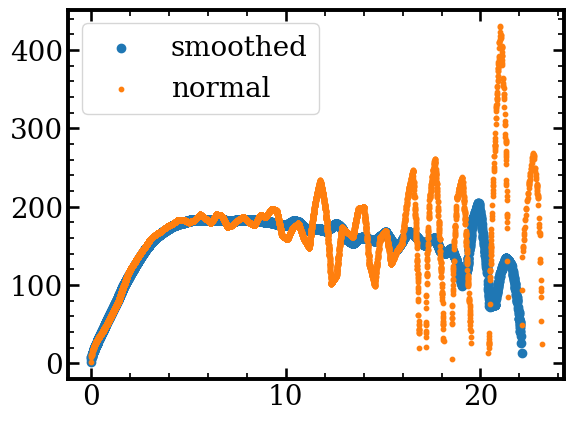

In [171]:
smoothed_interp_g = np.array([smooth_gradient_interp(i) for i in rstars])
smoothed_vcirc = np.sqrt(rstars * smoothed_interp_g)

plt.scatter(rstars/kpc2km,smoothed_vcirc,label='smoothed')
plt.scatter(masked_rstars/kpc2km,vcirc,s = 10,label='normal')
plt.legend()

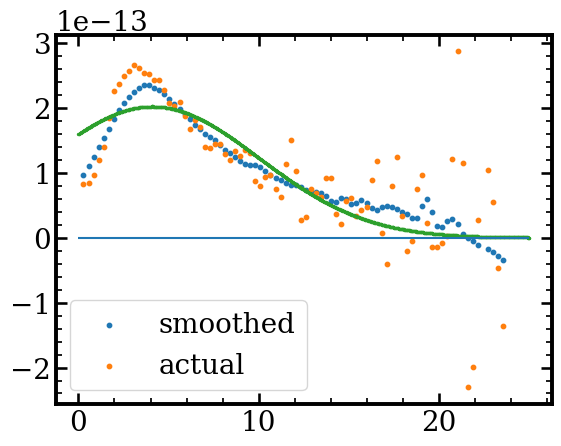

In [148]:
smoothed_g = savgol_filter(grad, window_length=15, polyorder=1)

smooth_gradient_interp = interp1d(pos*kpc2km, smoothed_g, kind='linear', fill_value="extrapolate")

x = pos*kpc2km
params, covariance = curve_fit(gaussian,x,grad,p0 = [2.2e-13,3*kpc2km,5*kpc2km])
xfit = np.linspace(0,25,1000)*kpc2km
yfit = gaussian(xfit,params[0],params[1],params[2])

# plt.scatter(rstars/kpc2km,0.5*(rstars)*np.array([smooth_gradient_interp(i) for i in rstars]),s=5,alpha=0.5,label='interpolated')
# plt.scatter(pos,0.5*(pos*kpc2km)*np.array([smooth_gradient_interp(i*kpc2km) for i in pos]))
plt.scatter(pos,smoothed_g,s = 10,label='smoothed')
plt.scatter(pos,grad,s = 10,label='actual')
plt.scatter(xfit/kpc2km,yfit,s=2)
plt.hlines(0,0,25)
# plt.xlim(0,50)
# plt.ylim(-100,20000)
plt.legend()

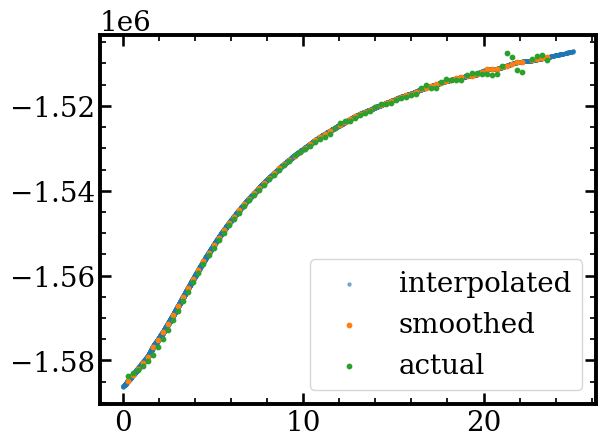

In [96]:
smoothed_p = savgol_filter(potential_binned, window_length=10, polyorder=1)
smoothed_potental_interp = interp1d(pos*kpc2km, smoothed_p, kind='linear', fill_value="extrapolate")

plt.scatter(rstars/kpc2km,np.array([smoothed_potental_interp(i) for i in rstars]),s=5,alpha=0.5,label='interpolated')
plt.scatter(pos,smoothed_p,s = 10,label='smoothed')
plt.scatter(pos,potential_binned,s = 10,label='actual')
plt.legend()

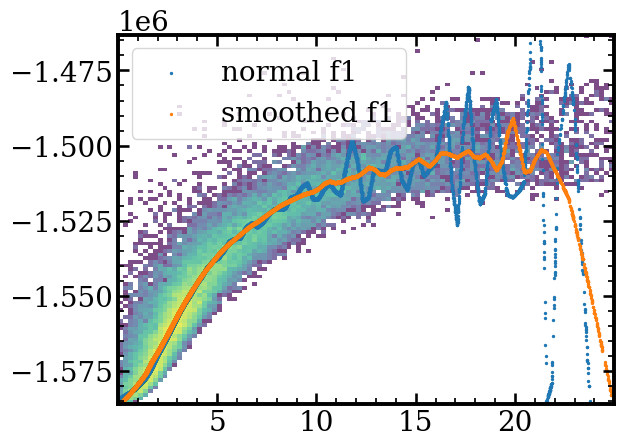

In [140]:
smoothed_f1 = 0.5*(rstars)*np.array([smooth_gradient_interp(i) for i in rstars]) + np.array([smoothed_potental_interp(i) for i in rstars])

counts1, xedges1, yedges1, im1 = plt.hist2d(rstars/kpc2km,f2,norm='log',bins=100,alpha=0.7)
plt.scatter(rstars/kpc2km,f1,label='normal f1',s=2)
plt.scatter(rstars/kpc2km,smoothed_f1,label='smoothed f1',s=2)
plt.legend()

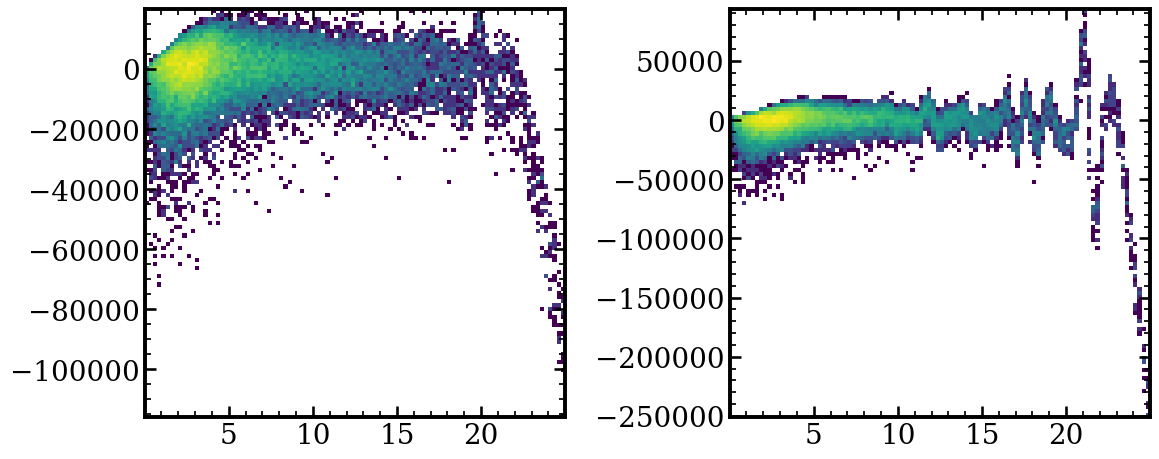

In [141]:
smoothedf = smoothed_f1 - f2

fig,axs = plt.subplots(1,2,figsize = (12,5))

counts1, xedges1, yedges1, im1 = axs[0].hist2d(rstars/kpc2km,smoothedf,norm='log',bins=100)
counts1, xedges1, yedges1, im1 = axs[1].hist2d(rstars/kpc2km,f[0],norm='log',bins=100)
plt.tight_layout()

Text(0.5, 1.0, 'Subhalo 52')

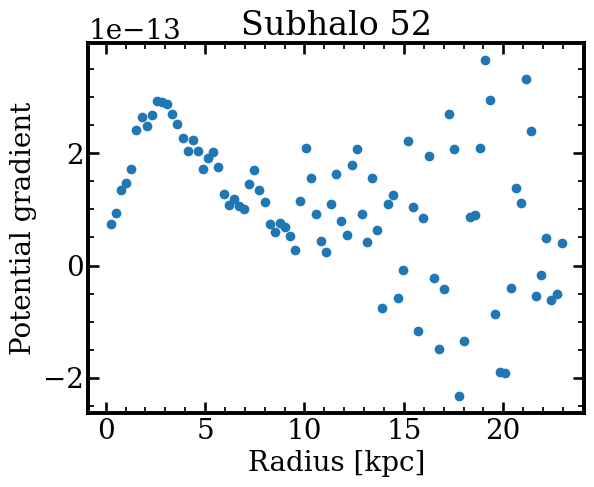

In [16]:
plt.scatter(pos,grad)
plt.xlabel("Radius [kpc]")
plt.ylabel("Potential gradient")
plt.title('Subhalo {}'.format(subhalo_id))
# plt.savefig('Plots/Subhalo_{}_gradphi_r'.format(subhalo_id))

In [12]:
mask = (ratio2 < 25) & (ratio2 > -25) & (~np.isnan(ratio2))
ratio2 = ratio2[mask]
Velocities = Velocities[mask]

In [13]:
disks = [(ratio2[i] > 0.5) & (ratio2[i] < 1.3) for i in range(len(ratio2))]
bulges = [ratio2[i] < 0.5 for i in range(len(ratio2))]
disk_vel = Velocities[disks]
bulge_vel = Velocities[bulges]

In [14]:
disk_vel_3d = np.sqrt(disk_vel[:,0]**2 + disk_vel[:,1]**2 + disk_vel[:,2]**2 )
bulge_vel_3d = np.sqrt(bulge_vel[:,0]**2 + bulge_vel[:,1]**2 + bulge_vel[:,2]**2 )

print("Disk sigma:",np.std(disk_vel_3d),"Bulge sigma:",np.std(bulge_vel_3d))

Disk sigma: 41.623806 Bulge sigma: 59.56956


In [25]:
Vel3d = np.linalg.norm(Velocities,axis=1)

In [26]:
np.std(Vel3d)

28.901012

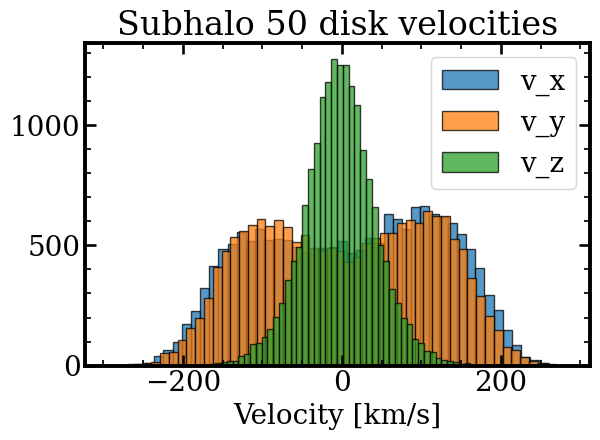

In [15]:
plt.hist(disk_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.75)
plt.hist(disk_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.75)
plt.hist(disk_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.75)

# plt.text(-550,7000,f"$\sigma:${np.std(disk_vel_3d):.2f} km/s")
plt.legend()
plt.title("Subhalo {} disk velocities".format(subhalo_id))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_vel_disk.png'.format(subhalo_id))

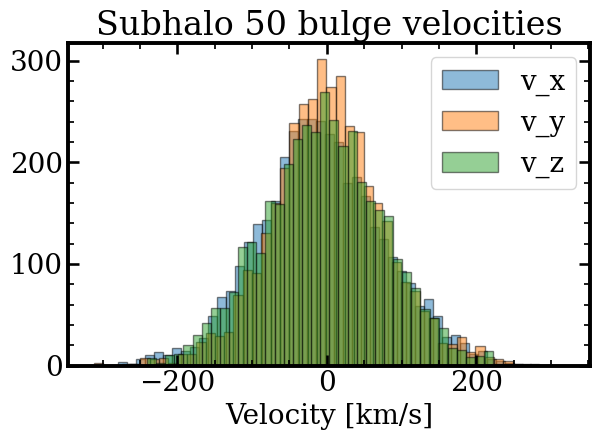

In [16]:
plt.hist(bulge_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.5)
plt.hist(bulge_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.5)
plt.hist(bulge_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.5)

# plt.text(-650,4000,f"$\sigma:${np.std(bulge_vel_3d):.2f} km/s")
plt.legend()
plt.title("Subhalo {} bulge velocities".format(subhalo_id))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_vel_bulge.png'.format(subhalo_id))

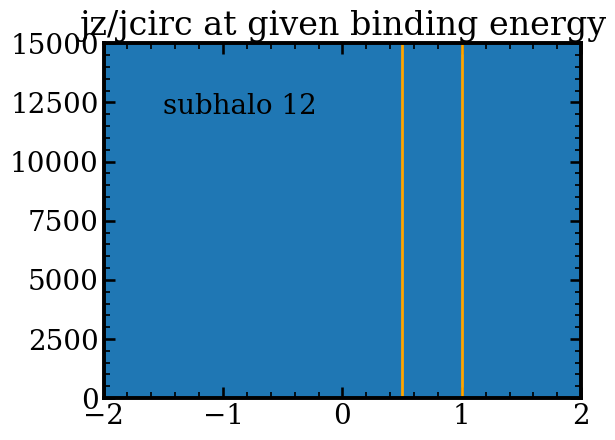

In [5]:
plt.hist(ratio2,bins=500,edgecolor='black')
plt.vlines([0.5,1],0,20000,color = 'orange',lw=2)
plt.ylim(0,15000)
plt.xlim(-2,2)
plt.title("jz/jcirc at given binding energy")
plt.text(-1.5,12000,'subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_jz_jcirc_e.png'.format(subhalo_id))

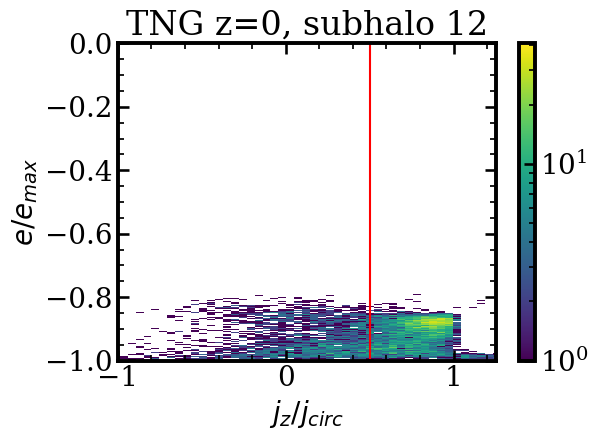

In [27]:
fig,ax=plt.subplots()

no_nans=~np.isnan(ratio2)
counts1, xedges1, yedges1, im1 = ax.hist2d(ratio2,e_bind_norm[mask],norm='log',bins=(1000,1000))

fig.colorbar(im1, ax=ax)
# ax.hlines([0.7,1.3],0,100,color='orange',lw=2,ls = '--')
# ax.hlines(1,0,100,color='orange',lw=2)
ax.vlines(0.5,-1,0,color='red')
plt.xlim(-1,1.25)
plt.ylim(-1,0)
plt.xlabel('$j_z/j_{circ}$')
plt.ylabel('$e/e_{max}$')
plt.title('TNG z=0, subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/TNG_subhalo_{}_emax_jz.png'.format(subhalo_id))

In [16]:
disks = [(ratio2[i] > 0.5) & (ratio2[i] < 1.3) for i in range(len(ratio2))]
bulges = [ratio2[i] < 0.5 for i in range(len(ratio2))]

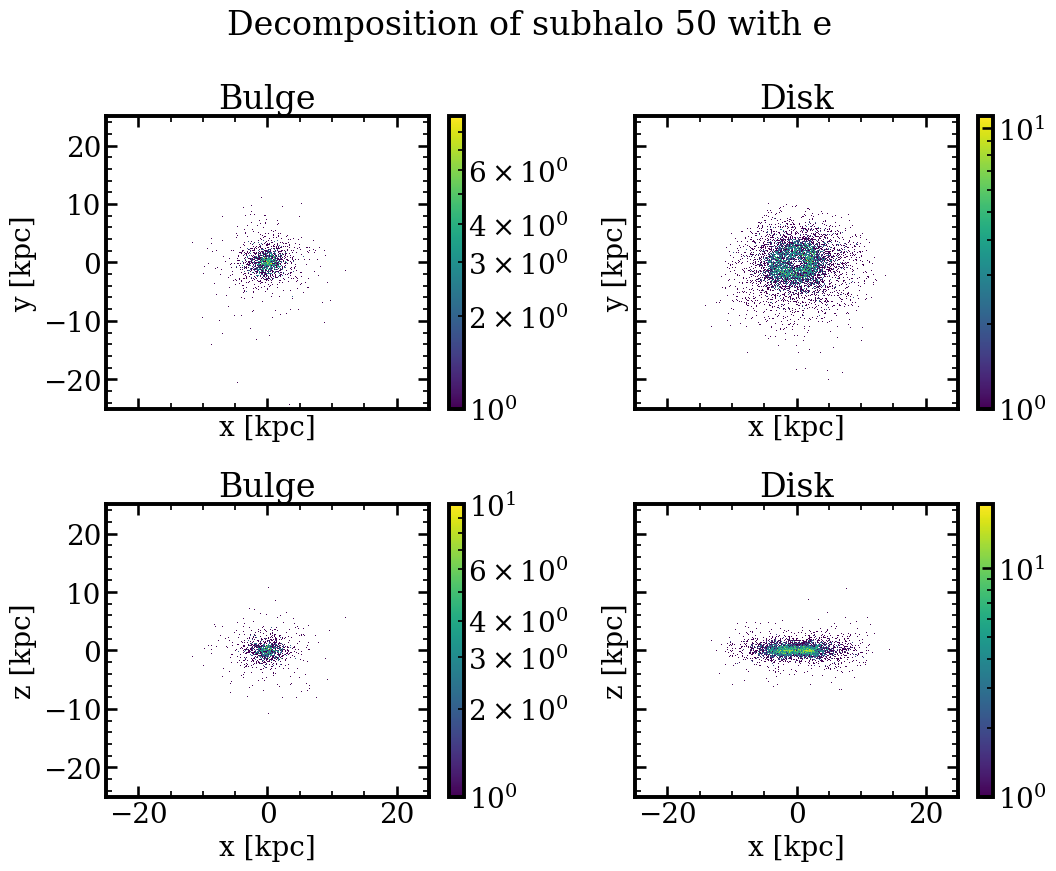

In [17]:
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-25,25)
    ax.set_ylim(-25,25)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Decomposition of subhalo {} with e'.format(subhalo_id))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp_0.5_e.png'.format(subhalo_id))

# Now testing binding energy function:

In [2]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
subhalo_id = 0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']
a = 1/(1+redshift)

In [26]:
Gas_Props

{'count': 0}

In [28]:
Gas_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 0, fields=fields)
Gas_Props

{'count': 0}

In [ ]:
fields = ['Coordinates','Masses']
basePath = '/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
snap_num = 99
subhalo_id = 10

Subhalovel = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloVel'])[subhalo_id]

BH_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 5, fields=fields)
Gas_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 0, fields=fields)
fields = ['Coordinates']
DM_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 1, fields=fields)
fields = ['Coordinates','Masses','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, subhalo_id, 4, fields=fields)

keys = ["Gas", "DM", "Stars", "BHs"]
Masses = {"Gas":Gas_Props['Masses'],"DM":7.5e6*np.ones(len(DM_Props)),"Stars":Star_Props['Masses'],"BHs":BH_Props['Masses']}
Coordinates = {"Gas":Gas_Props['Coordinates'],"DM":DM_Props,"Stars":Star_Props['Coordinates'],
               "BHs":BH_Props['Coordinates']}
Velocities = Star_Props['Velocities'] - Subhalovel

# Correcting units 
Msun2g = 1.989e33
kpc2km = 3.0857e16
Masses = {keys[i]:(Msun2g*1e10/h)*Masses[keys[i]] for i in range(len(keys))} # Units: g
Coordinates = {keys[i]:(kpc2km*a/h)*Coordinates[keys[i]] for i in range(len(keys))} # Units: km
Velocities *= np.sqrt(a) # Units: km/s

binding_energies = compute_binding_energy(Masses,Coordinates,Velocities)

In [ ]:
binding_energies

In [ ]:
old_binding = 0.5 * np.linalg.norm(Velocities,axis=1)**2 + Star_Props['Potential']

In [ ]:
old_binding